In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA
import cv2

from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit.utils import QuantumInstance
from qiskit import Aer
from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit.primitives import Estimator
from qiskit_machine_learning.connectors import TorchConnector
from qiskit.quantum_info import SparsePauliOp

In [3]:
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
X = mnist.data / 255.0  # Normalize pixel values to [0, 1]

# Resize each image from 28x28 to 16x16 using OpenCV
X_resized = np.array([
    cv2.resize(img.reshape(28, 28), (16, 16), interpolation=cv2.INTER_AREA)
    for img in X
])

X_flat = X_resized.reshape(-1, 256)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_flat)

train_inputs = torch.tensor(X_pca[:1000], dtype=torch.float32)

train_targets_full = torch.tensor(pca.inverse_transform(train_inputs.detach().numpy()), dtype=torch.float32)

In [4]:
n_qubits = 2
qc = QuantumCircuit(n_qubits)

x_params = ParameterVector('x', length=n_qubits)

theta_params = ParameterVector('θ', length=n_qubits)

# Encode each input dimension using Ry gates
for i in range(n_qubits):
    qc.ry(x_params[i], i)


# Apply trainable rotations on each qubit
for i in range(n_qubits):
    qc.ry(theta_params[i], i)
    
# Introduce entanglement
qc.cx(0, 1)

In [5]:
def psnr(original, reconstructed):
    mse = np.mean((original - reconstructed) ** 2)
    if mse == 0:
        return float('inf')
    PIXEL_MAX = 1.0  # data was normalized to [0, 1]
    return 20 * np.log10(PIXEL_MAX / np.sqrt(mse))

In [6]:
def reconstruction_accuracy(original, reconstructed, threshold=0.1):
    diff = np.abs(original - reconstructed)
    correct_pixels = (diff < threshold).sum()
    total_pixels = diff.size
    return correct_pixels / total_pixels * 100

In [7]:
# Use a statevector simulator (for exact simulation)
quantum_instance = QuantumInstance(Aer.get_backend('statevector_simulator'))


# Define observables for each qubit (Pauli-Z)
observables = [
    SparsePauliOp.from_list([("Z", 1)]).tensor(SparsePauliOp.from_list([("I", 1)])),
    SparsePauliOp.from_list([("I", 1)]).tensor(SparsePauliOp.from_list([("Z", 1)])),
]

estimator = Estimator()
qnn = EstimatorQNN(
    circuit=qc,
    input_params=x_params,
    weight_params=theta_params,
    estimator=estimator,
    observables=observables,
)

qnn_layer = TorchConnector(qnn)

/var/folders/l1/zcqs96sj4cd76hx4z8_30lt00000gn/T/ipykernel_12349/1227059095.py:2: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(Aer.get_backend('statevector_simulator'))


In [8]:
class QAEModel(nn.Module):
    def __init__(self, latent_dim=2, output_dim=256):
        super(QAEModel, self).__init__()
        self.encoder = qnn_layer  # Quantum encoder outputs latent representation (2D)
        
        # Classical decoder: maps latent vector back to the original flattened image (256D)
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim)
        )
        
    def forward(self, x):
        latent = self.encoder(x)
        reconstruction = self.decoder(latent)
        return reconstruction

model = QAEModel()

In [9]:
def main():
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.9)
    loss_fn = nn.MSELoss()
    num_epochs = 200

    loss_history = []
    best_loss = float('inf')
    epochs_no_improve = 0
    patience = 25

    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        
        outputs = model(train_inputs)
        loss = loss_fn(outputs, train_targets_full)
        loss.backward()
        optimizer.step()
        scheduler.step()

        loss_history.append(loss.item())

        with torch.no_grad():
            recon_np = outputs.numpy()
            originals = train_targets_full.numpy()
            acc = reconstruction_accuracy(originals, recon_np)
            psnr_val = psnr(originals, recon_np)

        if (epoch+1) % 10 == 0:
            print(f"Epoch {epoch+1}: Loss = {loss.item():.4f} | Acc = {acc:.2f}% | PSNR = {psnr_val:.2f} dB | LR = {scheduler.get_last_lr()[0]:.5f}")

        # --- Early stopping check ---
        if loss.item() < best_loss - 1e-4:
            best_loss = loss.item()
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"\nEarly stopping at epoch {epoch}. Best Loss: {best_loss:.4f}")
                break

    plt.figure(figsize=(8, 4))
    plt.plot(loss_history, 'm-')
    plt.xlabel("Epoch")
    plt.ylabel("MSE Loss")
    plt.title("QAE Training Loss on MNIST (16x16)")
    plt.grid(True)
    plt.show()

    with torch.no_grad():
        reconstructed = model(train_inputs).numpy()

    fig, axes = plt.subplots(2, 10, figsize=(15, 3))
    for i in range(10):
        original_img = pca.inverse_transform(train_inputs[i].numpy()).reshape(16, 16)
        axes[0, i].imshow(original_img, cmap='gray')
        axes[0, i].axis('off')
        
        recon_img = reconstructed[i].reshape(16, 16)
        axes[1, i].imshow(recon_img, cmap='gray')
        axes[1, i].axis('off')

    axes[0, 0].set_title("Originals", fontsize=10)
    axes[1, 0].set_title("Reconstructed", fontsize=10)
    plt.suptitle("Quantum Autoencoder Reconstruction on MNIST (16x16)", fontsize=14)
    plt.tight_layout()
    plt.show()

Epoch 10: Loss = 0.0142 | Acc = 65.91% | PSNR = 18.49 dB | LR = 0.00900
Epoch 20: Loss = 0.0077 | Acc = 83.24% | PSNR = 21.16 dB | LR = 0.00810
Epoch 30: Loss = 0.0058 | Acc = 87.21% | PSNR = 22.40 dB | LR = 0.00729
Epoch 40: Loss = 0.0049 | Acc = 89.08% | PSNR = 23.08 dB | LR = 0.00656
Epoch 50: Loss = 0.0044 | Acc = 90.00% | PSNR = 23.61 dB | LR = 0.00590
Epoch 60: Loss = 0.0039 | Acc = 90.93% | PSNR = 24.04 dB | LR = 0.00531
Epoch 70: Loss = 0.0036 | Acc = 91.69% | PSNR = 24.38 dB | LR = 0.00478
Epoch 80: Loss = 0.0034 | Acc = 92.20% | PSNR = 24.68 dB | LR = 0.00430
Epoch 90: Loss = 0.0032 | Acc = 92.69% | PSNR = 24.95 dB | LR = 0.00387
Epoch 100: Loss = 0.0030 | Acc = 93.09% | PSNR = 25.20 dB | LR = 0.00349
Epoch 110: Loss = 0.0029 | Acc = 93.49% | PSNR = 25.42 dB | LR = 0.00314
Epoch 120: Loss = 0.0027 | Acc = 93.83% | PSNR = 25.61 dB | LR = 0.00282
Epoch 130: Loss = 0.0026 | Acc = 94.13% | PSNR = 25.78 dB | LR = 0.00254
Epoch 140: Loss = 0.0025 | Acc = 94.40% | PSNR = 25.95 dB | 

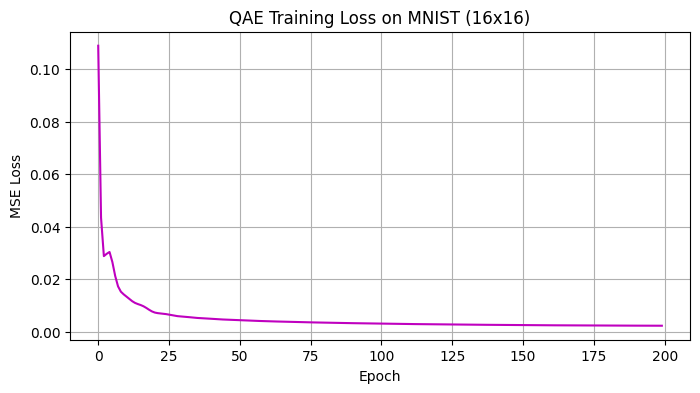

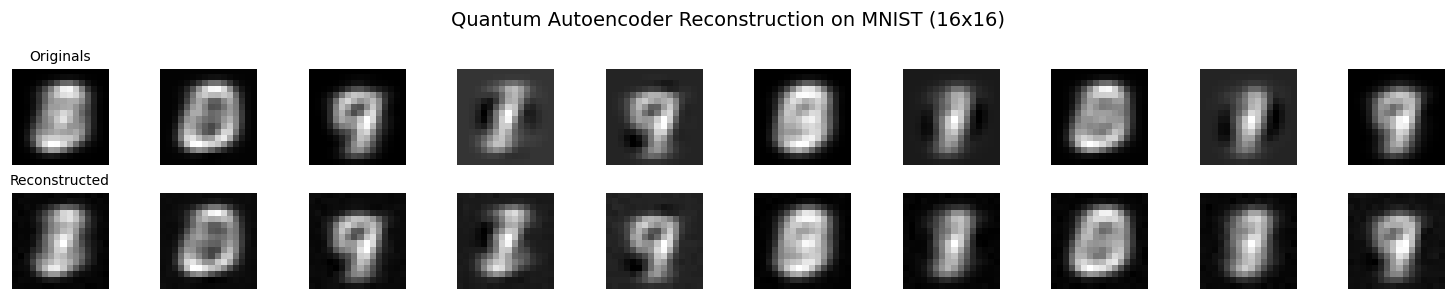

In [10]:
if __name__ == "__main__":
    main()

Epoch 0: Loss = 0.0189 | Acc = 63.76% | PSNR = 17.24 dB | LR = 0.01000
Epoch 10: Loss = 0.0112 | Acc = 78.13% | PSNR = 19.52 dB | LR = 0.00900
Epoch 20: Loss = 0.0070 | Acc = 85.38% | PSNR = 21.56 dB | LR = 0.00810
Epoch 30: Loss = 0.0062 | Acc = 87.00% | PSNR = 22.10 dB | LR = 0.00729
Epoch 40: Loss = 0.0054 | Acc = 87.99% | PSNR = 22.66 dB | LR = 0.00656
Epoch 50: Loss = 0.0050 | Acc = 88.58% | PSNR = 22.97 dB | LR = 0.00590
Epoch 60: Loss = 0.0048 | Acc = 88.96% | PSNR = 23.19 dB | LR = 0.00531
Epoch 70: Loss = 0.0046 | Acc = 89.23% | PSNR = 23.33 dB | LR = 0.00478
Epoch 80: Loss = 0.0045 | Acc = 89.49% | PSNR = 23.45 dB | LR = 0.00430
Epoch 90: Loss = 0.0044 | Acc = 89.67% | PSNR = 23.56 dB | LR = 0.00387


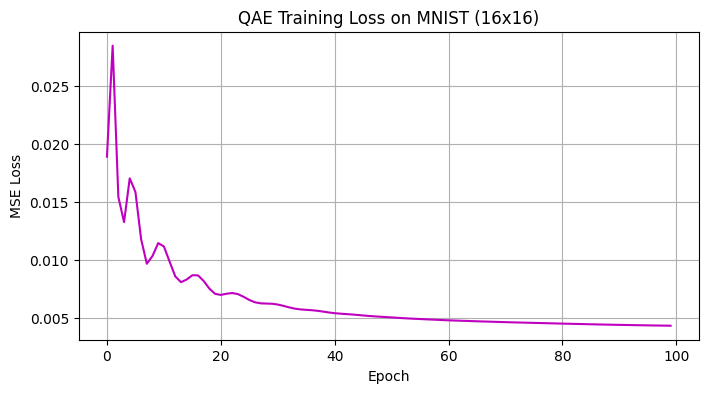

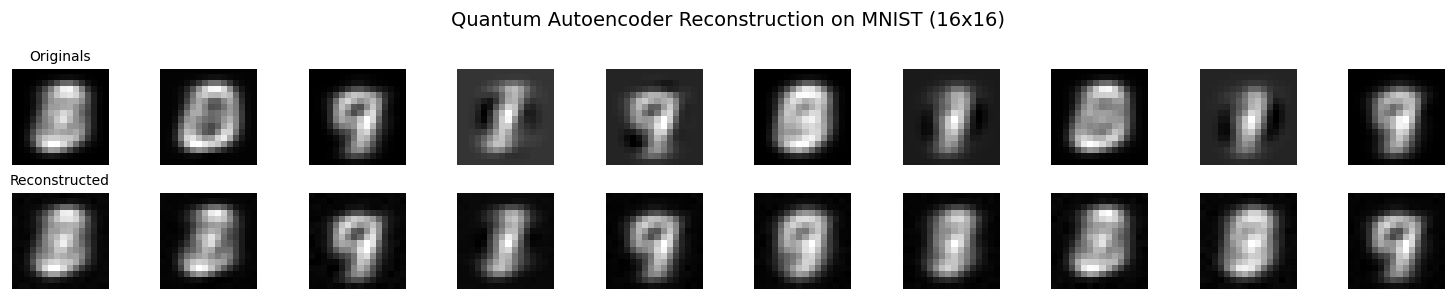

In [19]:
if __name__ == "__main__":
    main()